<h1>Aplicaciones Redes Neuronales<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Clasificación-Binaria" data-toc-modified-id="Clasificación-Binaria-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Clasificación Binaria</a></span><ul class="toc-item"><li><span><a href="#Preprocesamiento-de-datos" data-toc-modified-id="Preprocesamiento-de-datos-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Preprocesamiento de datos</a></span></li><li><span><a href="#Modelo-de-clasificación-con-una-red-neuronal" data-toc-modified-id="Modelo-de-clasificación-con-una-red-neuronal-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Modelo de clasificación con una red neuronal</a></span></li></ul></li><li><span><a href="#Clasificación-Multinomial" data-toc-modified-id="Clasificación-Multinomial-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Clasificación Multinomial</a></span></li><li><span><a href="#Regresión-Lineal" data-toc-modified-id="Regresión-Lineal-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Regresión Lineal</a></span></li><li><span><a href="#Conclusiones" data-toc-modified-id="Conclusiones-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Conclusiones</a></span></li></ul></div>

Caso tomado de [Applied Deep Learning - Part 2: Real World Case Studies](https://towardsdatascience.com/applied-deep-learning-part-2-real-world-case-studies-1bb4b142a585#581e) de   https://towardsdatascience.com.


# Ejemplos reales de aplicación de redes neuronales

Para este módulo estudiaremos tres casos diferentes de aplicación de redes neuronales. El objetivo del ejercicio es que al final tengamos clara la forma en la cual se diseña una red neuronal para resolver un problema real, cada caso consiste en una situación distinta de aplicación que utilizan el mismo modelo. Iniciamos con una clasificación binaria, luego una clasificación multiclase y finalmente una regresión.

## Clasificación Binaria

Usaremos un conjunto de datos de Análisis de recursos humanos de Kaggle. La idea es predecir si un empleado dejará una compañía en función de diversas características, como la cantidad de proyectos en los que trabajó, el tiempo que pasó en la empresa, la última revisión de desempeño, el salario, entre otros. 

Contamos con un conjunto de datos de 15,000 registros y 9 variables, entre las que se destaca la variable "left" que será nuestra variable objetivo. Dicha variable admite valores 0 o 1 donde 1 significa que el empleado se ha ido.

### Preprocesamiento de datos

Siempre recuerde hacer un preprocesamiento de datos adecuado, la idea es responder las siguientes preguntas:

* Qué tipo de características tenemos: valoradas reales, categóricas o ambas?
* ¿Alguna de las funciones necesita normalización?
* ¿Tenemos valores nulos?
* ¿Cuál es la distribución de etiquetas? ¿Están las clases desequilibradas?
* ¿Existe una correlación entre las características?

Empecemos llamando las librerias importantes, creando algunas funciones útiles y finalmente cargando los datos:

In [2]:
#Paquetes
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')
pd.options.display.float_format = '{:,.2f}'.format
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 200)

from __future__ import print_function
from datetime import datetime
from matplotlib.colors import ListedColormap
from sklearn.datasets import make_classification, make_moons, make_circles
from sklearn.metrics import confusion_matrix, classification_report, mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LogisticRegression
from sklearn.utils import shuffle
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization, Activation
from tensorflow.keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras.utils.np_utils import to_categorical
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, KFold
import keras.backend as K
from keras.wrappers.scikit_learn import KerasClassifier

In [24]:
#Funciones útiles
def plot_decision_boundary(func, X, y, figsize=(9, 6)):
    amin, bmin = X.min(axis=0) - 0.1
    amax, bmax = X.max(axis=0) + 0.1
    hticks = np.linspace(amin, amax, 101)
    vticks = np.linspace(bmin, bmax, 101)
    
    aa, bb = np.meshgrid(hticks, vticks)
    ab = np.c_[aa.ravel(), bb.ravel()]
    c = func(ab)
    cc = c.reshape(aa.shape)

    cm = plt.cm.RdBu
    cm_bright = ListedColormap(['#FF0000', '#0000FF'])
    
    fig, ax = plt.subplots(figsize=figsize)
    contour = plt.contourf(aa, bb, cc, cmap=cm, alpha=0.8)
    
    ax_c = fig.colorbar(contour)
    ax_c.set_label("$P(y = 1)$")
    ax_c.set_ticks([0, 0.25, 0.5, 0.75, 1])
    
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cm_bright)
    plt.xlim(amin, amax)
    plt.ylim(bmin, bmax)

def plot_multiclass_decision_boundary(model, X, y):
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 101), np.linspace(y_min, y_max, 101))
    cmap = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])

    Z = model.predict_classes(np.c_[xx.ravel(), yy.ravel()], verbose=0)
    Z = Z.reshape(xx.shape)
    fig = plt.figure(figsize=(8, 8))
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.8)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    
def plot_data(X, y, figsize=None):
    if not figsize:
        figsize = (8, 6)
    plt.figure(figsize=figsize)
    plt.plot(X[y==0, 0], X[y==0, 1], 'or', alpha=0.5, label=0)
    plt.plot(X[y==1, 0], X[y==1, 1], 'ob', alpha=0.5, label=1)
    plt.xlim((min(X[:, 0])-0.1, max(X[:, 0])+0.1))
    plt.ylim((min(X[:, 1])-0.1, max(X[:, 1])+0.1))
    plt.legend()

def plot_loss_accuracy(history):
    historydf = pd.DataFrame(history.history, index=history.epoch)
    plt.figure(figsize=(8, 6))
    historydf.plot(ylim=(0, max(1, historydf.values.max())))
    loss = history.history['loss'][-1]
    acc = history.history['accuracy'][-1]
    plt.title('Loss: %.3f, Accuracy: %.3f' % (loss, acc))

def plot_loss(history):
    historydf = pd.DataFrame(history.history, index=history.epoch)
    plt.figure(figsize=(8, 6))
    historydf.plot(ylim=(0, historydf.values.max()))
    plt.title('Loss: %.3f' % history.history['loss'][-1])
    
def plot_confusion_matrix(model, X, y):
    y_pred = model.predict(X, verbose=0)
    y_pred= np.argmax(y_pred, axis=1)
    plt.figure(figsize=(8, 6))
    sns.heatmap(pd.DataFrame(confusion_matrix(y, y_pred)), annot=True, fmt='d', cmap='GnBu', alpha=0.8, vmin=0)

def plot_compare_histories(history_list, name_list, plot_accuracy=True):
    dflist = []
    min_epoch = len(history_list[0].epoch)
    losses = []
    for history in history_list:
        h = {key: val for key, val in history.history.items() if not key.startswith('val_')}
        dflist.append(pd.DataFrame(h, index=history.epoch))
        min_epoch = min(min_epoch, len(history.epoch))
        losses.append(h['loss'][-1])

    historydf = pd.concat(dflist, axis=1)

    metrics = dflist[0].columns
    idx = pd.MultiIndex.from_product([name_list, metrics], names=['model', 'metric'])
    historydf.columns = idx
    
    plt.figure(figsize=(6, 8))

    ax = plt.subplot(211)
    historydf.xs('loss', axis=1, level='metric').plot(ylim=(0,1), ax=ax)
    plt.title("Training Loss: " + ' vs '.join([str(round(x, 3)) for x in losses]))
    
    if plot_accuracy:
        ax = plt.subplot(212)
        historydf.xs('acc', axis=1, level='metric').plot(ylim=(0,1), ax=ax)
        plt.title("Accuracy")
        plt.xlabel("Epochs")
    
    plt.xlim(0, min_epoch-1)
    plt.tight_layout()
    
def make_sine_wave():
    c = 3
    num = 2400
    step = num/(c*4)
    np.random.seed(0)
    x0 = np.linspace(-c*np.pi, c*np.pi, num)
    x1 = np.sin(x0)
    noise = np.random.normal(0, 0.1, num) + 0.1
    noise = np.sign(x1) * np.abs(noise)
    x1  = x1 + noise
    x0 = x0 + (np.asarray(range(num)) / step) * 0.3
    X = np.column_stack((x0, x1))
    y = np.asarray([int((i/step)%2==1) for i in range(len(x0))])
    return X, y

def make_multiclass(N=500, D=2, K=3):
    """
    N: number of points per class
    D: dimensionality
    K: number of classes
    """
    np.random.seed(0)
    X = np.zeros((N*K, D))
    y = np.zeros(N*K)
    for j in range(K):
        ix = range(N*j, N*(j+1))
        # radius
        r = np.linspace(0.0,1,N)
        # theta
        t = np.linspace(j*4,(j+1)*4,N) + np.random.randn(N)*0.2
        X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
        y[ix] = j
    fig = plt.figure(figsize=(6, 6))
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu, alpha=0.8)
    plt.xlim([-1,1])
    plt.ylim([-1,1])
    return X, y

In [5]:
#Datos
DF=pd.read_csv('HR.csv')
DF

,satisfaction_level,last_evaluation,number_project,average_monthly_hours,time_spend_company,Work_accident,promotion_last_5years,sales,salary,left
0,0.38,0.53,2,157,3,0,0,sales,low,1
1,0.80,0.86,5,262,6,0,0,sales,medium,1
2,0.11,0.88,7,272,4,0,0,sales,medium,1
3,0.72,0.87,5,223,5,0,0,sales,low,1
4,0.37,0.52,2,159,3,0,0,sales,low,1
...,...,...,...,...,...,...,...,...,...,...
14994,0.40,0.57,2,151,3,0,0,support,low,1
14995,0.37,0.48,2,160,3,0,0,support,low,1
14996,0.37,0.53,2,143,3,0,0,support,low,1
14997,0.11,0.96,6,280,4,0,0,support,low,1


Respondamos la primera pregunta, tipo de datos y resumen:

In [6]:
DF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14999 entries, 0 to 14998
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   satisfaction_level     14999 non-null  float64
 1   last_evaluation        14999 non-null  float64
 2   number_project         14999 non-null  int64  
 3   average_monthly_hours  14999 non-null  int64  
 4   time_spend_company     14999 non-null  int64  
 5   Work_accident          14999 non-null  int64  
 6   promotion_last_5years  14999 non-null  int64  
 7   sales                  14999 non-null  object 
 8   salary                 14999 non-null  object 
 9   left                   14999 non-null  int64  
dtypes: float64(2), int64(6), object(2)
memory usage: 1.1+ MB


Una inspección rápida para saber si debemos estandarizar los datos:

In [7]:
DF.describe()

,satisfaction_level,last_evaluation,number_project,average_monthly_hours,time_spend_company,Work_accident,promotion_last_5years,left
count,"14,999.00","14,999.00","14,999.00","14,999.00","14,999.00","14,999.00","14,999.00","14,999.00"
mean,0.61,0.72,3.80,201.05,3.50,0.14,0.02,0.24
std,0.25,0.17,1.23,49.94,1.46,0.35,0.14,0.43
min,0.09,0.36,2.00,96.00,2.00,0.00,0.00,0.00
25%,0.44,0.56,3.00,156.00,3.00,0.00,0.00,0.00
50%,0.64,0.72,4.00,200.00,3.00,0.00,0.00,0.00
75%,0.82,0.87,5.00,245.00,4.00,0.00,0.00,0.00
max,1.00,1.00,7.00,310.00,10.00,1.00,1.00,1.00


Veamos sus correlaciones:

<AxesSubplot:>

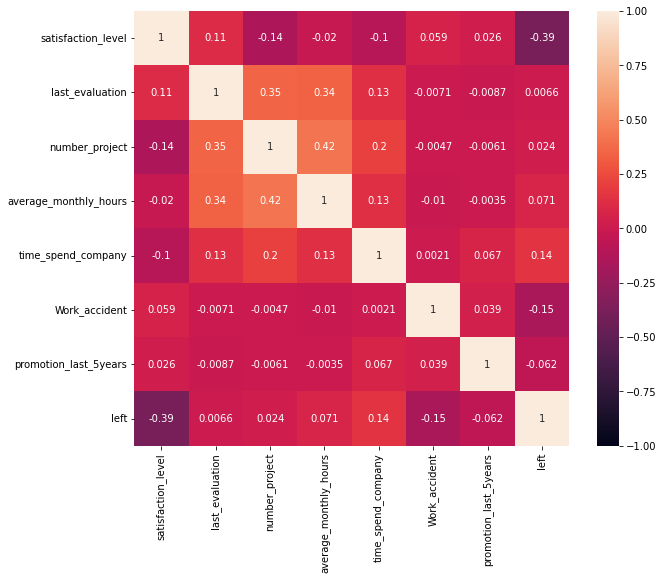

In [8]:
plt.figure(figsize=(10, 8))
sns.heatmap(DF.corr(), annot=True, square=True, vmin=-1, vmax=1)

Ahora veamos la distribución de cada una de las variables para ver cuáles necesitan estandarización. Selccionamos para ello 

* average_monthly_hours,
* number_project y 
* time_spend_company. 

¿Por qué?

In [12]:
df = DF.copy()

ss = StandardScaler()
scale_features = ['average_monthly_hours', 'number_project', 'time_spend_company']
df[scale_features] = ss.fit_transform(df[scale_features])
df


,satisfaction_level,last_evaluation,number_project,average_monthly_hours,time_spend_company,Work_accident,promotion_last_5years,sales,salary,left
0,0.38,0.53,-1.46,-0.88,-0.34,0,0,sales,low,1
1,0.80,0.86,0.97,1.22,1.71,0,0,sales,medium,1
2,0.11,0.88,2.59,1.42,0.34,0,0,sales,medium,1
3,0.72,0.87,0.97,0.44,1.03,0,0,sales,low,1
4,0.37,0.52,-1.46,-0.84,-0.34,0,0,sales,low,1
...,...,...,...,...,...,...,...,...,...,...
14994,0.40,0.57,-1.46,-1.00,-0.34,0,0,support,low,1
14995,0.37,0.48,-1.46,-0.82,-0.34,0,0,support,low,1
14996,0.37,0.53,-1.46,-1.16,-0.34,0,0,support,low,1
14997,0.11,0.96,1.78,1.58,0.34,0,0,support,low,1


Ahora bien, estamos muy contentos con nuestra base estandarizada, sin embargo nos enfrentamos a otro problema, las variables categóricas. Recuerden que cuando se definió el perceptrón lo hicimos como un elemento matemático y como tal debe tener entradas numéricas, no obstante, como lo vimos en clases pasadas entendimos que una forma de volver numérica una variable categórica es usando variables dummies:

In [13]:
categorical_features = ['sales', 'salary']
df_cat = pd.get_dummies(df[categorical_features])
df = df.drop(categorical_features, axis=1)
df = pd.concat([df, df_cat], axis=1)
df.head()

,satisfaction_level,last_evaluation,number_project,average_monthly_hours,time_spend_company,Work_accident,promotion_last_5years,left,sales_IT,sales_RandD,sales_accounting,sales_hr,sales_management,sales_marketing,sales_product_mng,sales_sales,sales_support,sales_technical,salary_high,salary_low,salary_medium
0,0.38,0.53,-1.46,-0.88,-0.34,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0
1,0.80,0.86,0.97,1.22,1.71,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1
2,0.11,0.88,2.59,1.42,0.34,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1
3,0.72,0.87,0.97,0.44,1.03,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0
4,0.37,0.52,-1.46,-0.84,-0.34,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0


Los datos están listos pero falta la partición de la base en entrenamiento y testeo, como tenemos una base generosa utilizaremos el 30% de los registros para hacer testeo:

In [14]:
X = df.drop('left', axis=1).values
y = df['left'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(10499, 20) (10499,) (4500, 20) (4500,)


### Modelo de clasificación con una red neuronal

Ahora vamos a crear un modelo para predecir la variable left, aprovecharemois el desorden para jugar un poco con la tasa de aprendizaje:

In [15]:
bin_clas = Sequential()
bin_clas.add(Dense(32, input_shape=(X_train.shape[1],), activation='tanh'))
bin_clas.add(Dense(16, activation='tanh'))
bin_clas.add(Dense(1, activation='sigmoid'))

bin_clas.compile(Adam(lr=0.1), 'binary_crossentropy', metrics=['accuracy'])

bin_hist = bin_clas.fit(X_train, y_train, epochs=100)

Epoch 1/100
329/329 [==============================] - 1s 1ms/step - loss: 0.2657 - accuracy: 0.9003
Epoch 2/100
329/329 [==============================] - 0s 1ms/step - loss: 0.2584 - accuracy: 0.9109
Epoch 3/100
329/329 [==============================] - 0s 1ms/step - loss: 0.2681 - accuracy: 0.9033
Epoch 4/100
329/329 [==============================] - 0s 1ms/step - loss: 0.2639 - accuracy: 0.9007
Epoch 5/100
329/329 [==============================] - 1s 2ms/step - loss: 0.2693 - accuracy: 0.9034
Epoch 6/100
329/329 [==============================] - 0s 1ms/step - loss: 0.2938 - accuracy: 0.8910
Epoch 7/100
329/329 [==============================] - 0s 1ms/step - loss: 0.3113 - accuracy: 0.8938
Epoch 8/100
329/329 [==============================] - 0s 1ms/step - loss: 0.4570 - accuracy: 0.8274
Epoch 9/100
329/329 [==============================] - 0s 1ms/step - loss: 0.4318 - accuracy: 0.8306
Epoch 10/100
329/329 [==============================] - 0s 1ms/step - loss: 0.2863 - accura

<Figure size 576x432 with 0 Axes>

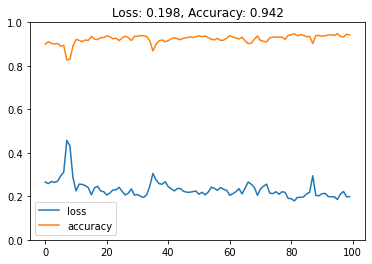

In [16]:
plot_loss_accuracy(bin_hist)

Ahora con una tasa de aprendizaje no tan complicada:

In [17]:
bin_clas = Sequential()
bin_clas.add(Dense(32, input_shape=(X_train.shape[1],), activation='tanh'))
bin_clas.add(Dense(16, activation='tanh'))
bin_clas.add(Dense(1, activation='sigmoid'))

bin_clas.compile(Adam(lr=0.005), 'binary_crossentropy', metrics=['accuracy'])

bin_hist = bin_clas.fit(X_train, y_train, epochs=100)

Epoch 1/100
329/329 [==============================] - 1s 2ms/step - loss: 0.2679 - accuracy: 0.8912
Epoch 2/100
329/329 [==============================] - 0s 1ms/step - loss: 0.1675 - accuracy: 0.9453
Epoch 3/100
329/329 [==============================] - 0s 1ms/step - loss: 0.1464 - accuracy: 0.9545
Epoch 4/100
329/329 [==============================] - 0s 1ms/step - loss: 0.1346 - accuracy: 0.9582
Epoch 5/100
329/329 [==============================] - 0s 1ms/step - loss: 0.1282 - accuracy: 0.9592
Epoch 6/100
329/329 [==============================] - 0s 1ms/step - loss: 0.1219 - accuracy: 0.9626
Epoch 7/100
329/329 [==============================] - 0s 1ms/step - loss: 0.1168 - accuracy: 0.9619
Epoch 8/100
329/329 [==============================] - 0s 1ms/step - loss: 0.1143 - accuracy: 0.9646
Epoch 9/100
329/329 [==============================] - 0s 1ms/step - loss: 0.1125 - accuracy: 0.9651
Epoch 10/100
329/329 [==============================] - 0s 1ms/step - loss: 0.1087 - accura

<Figure size 576x432 with 0 Axes>

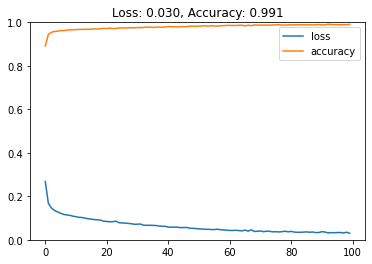

In [18]:
plot_loss_accuracy(bin_hist)

Buena aproximación, grafiquemos la matriz de confusión:

In [27]:
y_pred = bin_clas.predict(X_test, verbose=0)
y_pred=[1 if y>=0.5 else 0 for y in y_pred]
print(classification_report(y_test, y_pred))
confusion_matrix(y_test, y_pred)
#plot_confusion_matrix(bin_clas, X_test, y_test)

              precision    recall  f1-score   support

           0       0.98      0.98      0.98      3462
           1       0.93      0.94      0.94      1038

    accuracy                           0.97      4500
   macro avg       0.96      0.96      0.96      4500
weighted avg       0.97      0.97      0.97      4500



array([[3389,   73],
       [  62,  976]], dtype=int64)

Veamos como nos fue en la de entrenamiento:

In [28]:
y_pred = bin_clas.predict(X_train, verbose=0)
y_pred=[1 if y>=0.5 else 0 for y in y_pred]
print(classification_report(y_train, y_pred))
#plot_confusion_matrix(bin_clas, X_train, y_train)

              precision    recall  f1-score   support

           0       0.99      1.00      0.99      7966
           1       0.99      0.97      0.98      2533

    accuracy                           0.99     10499
   macro avg       0.99      0.99      0.99     10499
weighted avg       0.99      0.99      0.99     10499



## Clasificación Multinomial

Ahora trabajaremos con otra base [Car Evaluation DataBase](https://archive.ics.uci.edu/ml/datasets/Car+Evaluation) se derivó de un modelo de decisión jerárquico simple desarrollado originalmente para la demostración de DEX, M. Bohanec, V. Rajkovic: Sistema experto para la toma de decisiones. Sistemica 1 (1), págs. 145-157, 1990.). El modelo evalúa los coches de acuerdo con la siguiente estructura conceptual:

Aceptabilidad del coche CAR
* PRECIO precio total
        buying : precio de compra
        maint price: precio de mantenimiento
* Características técnicas TECH
* CONFORT:  comodidad
        doors:  número de puertas
        persons capacity:  personas para llevar
        lug_boot: el tamaño del maletero
        safety:  seguridad estimada del coche

La base de datos relaciona directamente el automóvil con los seis atributos de entrada: compra, mantenimiento, puertas, personas, maletero, seguridad.

Debido a la estructura de concepto subyacente conocida, esta base de datos puede ser particularmente útil para probar métodos de inducción constructiva y descubrimiento de estructuras.

Información de atributos:

Valores de clase:

unacc, acc, good, vgood

Atributos:

* buying: vhigh, high, med, low.
* maint: vhigh, high, med, low.
* doors: 2, 3, 4, 5 or more.
* persons: 2, 4, more.
* lug_boot: small, med, big.
* safety: low, med, high.



In [29]:
DF2=pd.read_csv('car.data',header=None)
DF2.columns=['buying','maint','doors','persons','lug_boot','safety','clas']
DF2

,buying,maint,doors,persons,lug_boot,safety,clas
0,vhigh,vhigh,2,2,small,low,unacc
1,vhigh,vhigh,2,2,small,med,unacc
2,vhigh,vhigh,2,2,small,high,unacc
3,vhigh,vhigh,2,2,med,low,unacc
4,vhigh,vhigh,2,2,med,med,unacc
...,...,...,...,...,...,...,...
1723,low,low,5more,more,med,med,good
1724,low,low,5more,more,med,high,vgood
1725,low,low,5more,more,big,low,unacc
1726,low,low,5more,more,big,med,good


In [30]:
df=DF2.copy()
categorical_features=df.columns[:-1]
df_cat = pd.get_dummies(df[categorical_features])
df.drop(categorical_features, axis=1)
df = pd.concat([ df_cat,df['clas']], axis=1)
df

,buying_high,buying_low,buying_med,buying_vhigh,maint_high,maint_low,maint_med,maint_vhigh,doors_2,doors_3,doors_4,doors_5more,persons_2,persons_4,persons_more,lug_boot_big,lug_boot_med,lug_boot_small,safety_high,safety_low,safety_med,clas
0,0,0,0,1,0,0,0,1,1,0,0,0,1,0,0,0,0,1,0,1,0,unacc
1,0,0,0,1,0,0,0,1,1,0,0,0,1,0,0,0,0,1,0,0,1,unacc
2,0,0,0,1,0,0,0,1,1,0,0,0,1,0,0,0,0,1,1,0,0,unacc
3,0,0,0,1,0,0,0,1,1,0,0,0,1,0,0,0,1,0,0,1,0,unacc
4,0,0,0,1,0,0,0,1,1,0,0,0,1,0,0,0,1,0,0,0,1,unacc
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1723,0,1,0,0,0,1,0,0,0,0,0,1,0,0,1,0,1,0,0,0,1,good
1724,0,1,0,0,0,1,0,0,0,0,0,1,0,0,1,0,1,0,1,0,0,vgood
1725,0,1,0,0,0,1,0,0,0,0,0,1,0,0,1,1,0,0,0,1,0,unacc
1726,0,1,0,0,0,1,0,0,0,0,0,1,0,0,1,1,0,0,0,0,1,good


Como las variables de entrada son categóricas no hacemos ninguna estandarización, iniciamos planteando el modelo, en primer lugar adecuamos la bases:

In [31]:
X = np.asarray(df.values[:, :-1]).astype('float32')
y = np.asarray(pd.get_dummies(df['clas']).values).astype('float32')
print(X.shape, y.shape)

(1728, 21) (1728, 4)


Ahora definimos entrenamiento y testeo:

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
print(X_train.shape, y_train.shape,X_test.shape,y_test.shape)

(1382, 21) (1382, 4) (346, 21) (346, 4)


Finalmente definimos un modelo:

In [35]:
y_train

array([[0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       ...,
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.]], dtype=float32)

<Figure size 576x432 with 0 Axes>

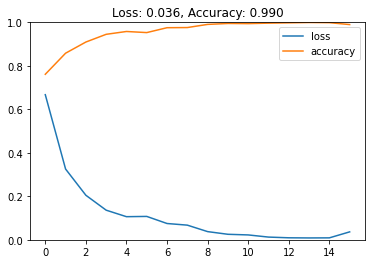

In [36]:
mul_clas = Sequential()
mul_clas.add(Dense(32, input_shape=(X.shape[1],), activation='relu'))
mul_clas.add(Dense(16, activation='relu'))
mul_clas.add(Dense(8, activation='relu'))
mul_clas.add(Dense(4, activation='softmax'))
mul_clas.compile(Adam(lr=0.01), loss='categorical_crossentropy', metrics=['accuracy'])

history = mul_clas.fit(X_train, y_train, epochs=16, verbose=0)
plot_loss_accuracy(history)

              precision    recall  f1-score   support

           0       0.99      0.96      0.97        78
           1       0.92      1.00      0.96        12
           2       0.99      1.00      0.99       243
           3       1.00      1.00      1.00        13

    accuracy                           0.99       346
   macro avg       0.98      0.99      0.98       346
weighted avg       0.99      0.99      0.99       346



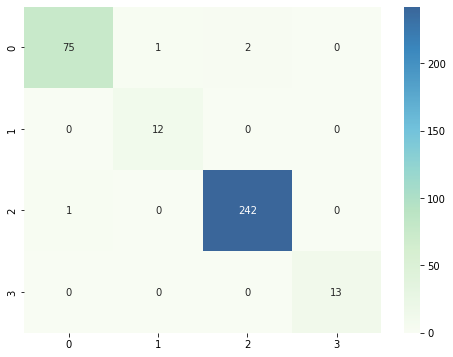

In [38]:
y_pred_class = mul_clas.predict(X_test, verbose=0)
y_pred_class = np.argmax(y_pred_class, axis=1)
y_test_class = np.argmax(y_test, axis=1)
print(classification_report(y_test_class, y_pred_class))
plot_confusion_matrix(mul_clas, X_test, y_test_class)

## Regresión Lineal

Usando la sintáxis de las redes neuronales modelaremos una regresión lineal, utilizaremos los datos de Kaggle para el caso [House Sales in King County, USA](https://www.kaggle.com/harlfoxem/housesalesprediction).  

In [39]:
DF3=pd.read_csv('houses_price.csv',index_col='id')
DF3

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
id,,,,,,,,,,,,,,,,,,,,
7129300520,20141013T000000,"221,900.00",3,1.00,1180,5650,1.00,0,0,3,7,1180,0,1955,0,98178,47.51,-122.26,1340,5650
6414100192,20141209T000000,"538,000.00",3,2.25,2570,7242,2.00,0,0,3,7,2170,400,1951,1991,98125,47.72,-122.32,1690,7639
5631500400,20150225T000000,"180,000.00",2,1.00,770,10000,1.00,0,0,3,6,770,0,1933,0,98028,47.74,-122.23,2720,8062
2487200875,20141209T000000,"604,000.00",4,3.00,1960,5000,1.00,0,0,5,7,1050,910,1965,0,98136,47.52,-122.39,1360,5000
1954400510,20150218T000000,"510,000.00",3,2.00,1680,8080,1.00,0,0,3,8,1680,0,1987,0,98074,47.62,-122.05,1800,7503
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
263000018,20140521T000000,"360,000.00",3,2.50,1530,1131,3.00,0,0,3,8,1530,0,2009,0,98103,47.70,-122.35,1530,1509
6600060120,20150223T000000,"400,000.00",4,2.50,2310,5813,2.00,0,0,3,8,2310,0,2014,0,98146,47.51,-122.36,1830,7200
1523300141,20140623T000000,"402,101.00",2,0.75,1020,1350,2.00,0,0,3,7,1020,0,2009,0,98144,47.59,-122.30,1020,2007


Hagamos una rápida exploración:

In [40]:
#pdp.ProfileReport(DF3)

Veamos la correlación entre variables:

<AxesSubplot:>

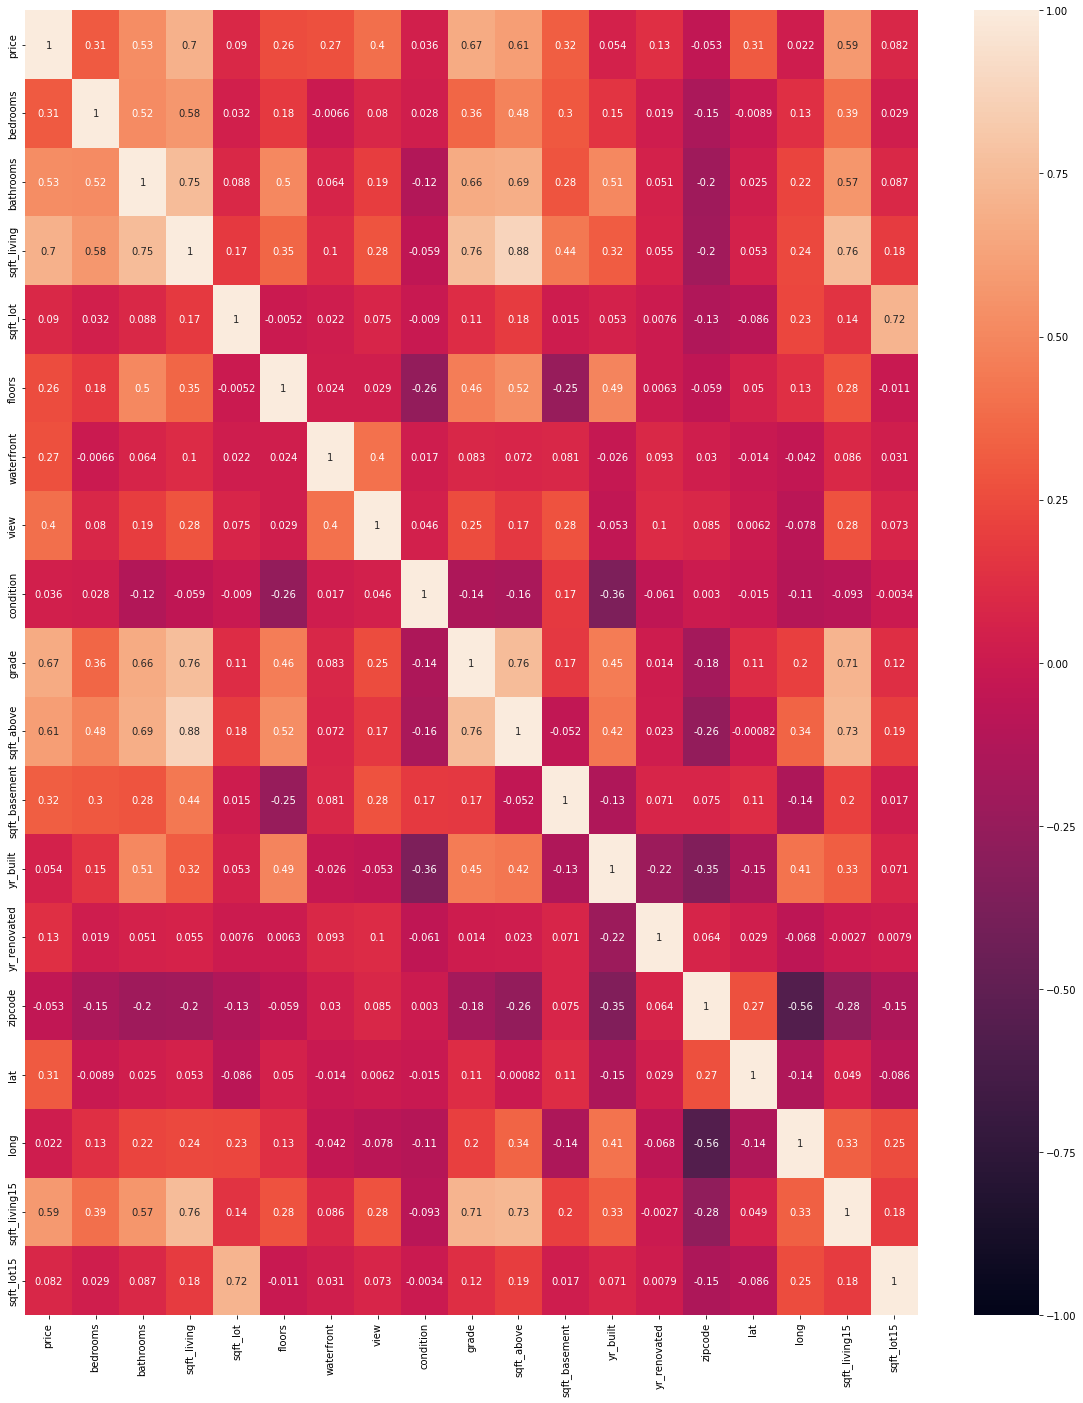

In [41]:
plt.figure(figsize=(20, 24))
sns.heatmap(DF3.corr(), annot=True, vmin=-1, vmax=1)

Las características relacionadas con pies cuadrados definitivamente deben estandarizarse, ya que los valores varían en miles y las características como el código postal deben clasificarse.

También tenemos un nuevo tipo de preprocesamiento que realizar, *bucketization*. Por ejemplo, la característica que contiene el año en que se construyó la casa (yr_built), varía de 1900 a 2015. Ciertamente podemos clasificarla con cada año perteneciente a una categoría distinta, pero entonces sería bastante escasa. Obtendríamos más señal si agrupamos esta función sin perder mucha información. Por ejemplo, si usamos cubos de 10 años, los años entre [1950, 1959] se colapsarían juntos. Probablemente sería suficiente saber que esta casa fue construida en la década de 1950 en lugar de en 1958 exactamente.

Otras características que se beneficiarían de la *bucketization* son la latitud y la longitud de la casa. La coordenada exacta no importa tanto, podemos redondear la coordenada al kilómetro más cercano. De esta manera, los valores de las características serán más densos e informativos. No existe una regla fija y estricta sobre los rangos que se deben usar en la agrupación en segmentos, se deciden principalmente por prueba y error.

Una última transformación que debemos hacer es el precio de la casa, actualmente su valor oscila entre $\$ 75 K$ y $\$ 7.7 M$. Un modelo que intenta predecir a una escala y variación tan grande sería muy inestable. Así que también normalizamos eso.


In [42]:
df = DF3.copy()

# Estandarizaciones
ss = StandardScaler()
scale_features = ['bathrooms', 'bedrooms', 'grade', 'sqft_above', 
                  'sqft_basement', 'sqft_living', 'sqft_living15', 'sqft_lot', 'sqft_lot15']
df[scale_features] = ss.fit_transform(df[scale_features])

# bucketization
bucketized_features = ['yr_built', 'yr_renovated', 'lat', 'long']

bins = range(1890, 2021, 10)
df['yr_built'] = pd.cut(df.yr_built, bins, labels=bins[:-1])

bins = list(range(1930, 2021, 10))
bins = [-10] + bins
df['yr_renovated'] = pd.cut(df.yr_renovated, bins, labels=bins[:-1])

bins = np.arange(47.00, 47.90, 0.05)
df['lat'] = pd.cut(df.lat, bins, labels=bins[:-1])

bins = np.arange(-122.60, -121.10, 0.05)
df['long'] = pd.cut(df.long, bins, labels=bins[:-1])

# Variables categóricas
df['date'] = [datetime.strptime(x, '%Y%m%dT000000').strftime('%Y-%m') for x in DF3['date'].values]
df['zipcode'] = df['zipcode'].astype('str')
categorical_features = ['zipcode', 'date']
categorical_features.extend(bucketized_features)
df_cat = pd.get_dummies(df[categorical_features])
df = df.drop(categorical_features, axis=1)
df = pd.concat([df, df_cat], axis=1)
df

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,sqft_living15,sqft_lot15,zipcode_98001,zipcode_98002,zipcode_98003,zipcode_98004,zipcode_98005,zipcode_98006,zipcode_98007,zipcode_98008,zipcode_98010,zipcode_98011,zipcode_98014,zipcode_98019,zipcode_98022,zipcode_98023,zipcode_98024,zipcode_98027,zipcode_98028,zipcode_98029,zipcode_98030,zipcode_98031,zipcode_98032,zipcode_98033,zipcode_98034,zipcode_98038,zipcode_98039,zipcode_98040,zipcode_98042,zipcode_98045,zipcode_98052,zipcode_98053,zipcode_98055,zipcode_98056,zipcode_98058,zipcode_98059,zipcode_98065,zipcode_98070,zipcode_98072,zipcode_98074,zipcode_98075,zipcode_98077,zipcode_98092,zipcode_98102,zipcode_98103,zipcode_98105,zipcode_98106,zipcode_98107,zipcode_98108,zipcode_98109,zipcode_98112,zipcode_98115,zipcode_98116,zipcode_98117,zipcode_98118,zipcode_98119,zipcode_98122,zipcode_98125,zipcode_98126,zipcode_98133,zipcode_98136,zipcode_98144,zipcode_98146,zipcode_98148,zipcode_98155,zipcode_98166,zipcode_98168,zipcode_98177,zipcode_98178,zipcode_98188,zipcode_98198,zipcode_98199,date_2014-05,date_2014-06,date_2014-07,date_2014-08,date_2014-09,date_2014-10,date_2014-11,date_2014-12,date_2015-01,date_2015-02,date_2015-03,date_2015-04,date_2015-05,yr_built_1890,yr_built_1900,yr_built_1910,yr_built_1920,yr_built_1930,yr_built_1940,yr_built_1950,yr_built_1960,yr_built_1970,yr_built_1980,yr_built_1990,yr_built_2000,yr_built_2010,yr_renovated_-10,yr_renovated_1930,yr_renovated_1940,yr_renovated_1950,yr_renovated_1960,yr_renovated_1970,yr_renovated_1980,yr_renovated_1990,yr_renovated_2000,yr_renovated_2010,lat_47.0,lat_47.05,lat_47.099999999999994,lat_47.14999999999999,lat_47.19999999999999,lat_47.249999999999986,lat_47.29999999999998,lat_47.34999999999998,lat_47.39999999999998,lat_47.449999999999974,lat_47.49999999999997,lat_47.54999999999997,lat_47.599999999999966,lat_47.64999999999996,lat_47.69999999999996,lat_47.74999999999996,lat_47.799999999999955,long_-122.6,long_-122.55,long_-122.5,long_-122.45,long_-122.4,long_-122.35000000000001,long_-122.30000000000001,long_-122.25000000000001,long_-122.20000000000002,long_-122.15000000000002,long_-122.10000000000002,long_-122.05000000000003,long_-122.00000000000003,long_-121.95000000000003,long_-121.90000000000003,long_-121.85000000000004,long_-121.80000000000004,long_-121.75000000000004,long_-121.70000000000005,long_-121.65000000000005,long_-121.60000000000005,long_-121.55000000000005,long_-121.50000000000006,long_-121.45000000000006,long_-121.40000000000006,long_-121.35000000000007,long_-121.30000000000007,long_-121.25000000000007,long_-121.20000000000007
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
7129300520,"221,900.00",-0.40,-1.45,-0.98,-0.23,1.00,0,0,3,-0.56,-0.73,-0.66,-0.94,-0.26,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6414100192,"538,000.00",-0.40,0.18,0.53,-0.19,2.00,0,0,3,-0.56,0.46,0.25,-0.43,-0.19,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5631500400,"180,000.00",-1.47,-1.45,-1.43,-0.12,1.00,0,0,3,-1.41,-1.23,-0.66,1.07,-0.17,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

Nos preparamos para hacer el modelo:

In [43]:
X = df.drop(['price'], axis=1).values
y = df['price'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

# Arreglo de outliers
factor = 5
y_train[np.abs(y_train - y_train.mean()) > (factor * y_train.std())] = y_train.mean() + factor*y_train.std()

# Estandarizar precio
ss_price = StandardScaler()
y_train = ss_price.fit_transform(y_train.reshape(-1, 1))
y_test = ss_price.transform(y_test.reshape(-1, 1))

(17290, 165) (17290,) (4323, 165) (4323,)


El modelo lineal no tendrá función de activación y la función de pérdida será el Error cuadrático medio:

<Figure size 576x432 with 0 Axes>

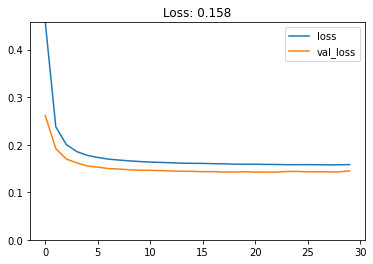

In [44]:
linr_model = Sequential()
linr_model.add(Dense(1, input_shape=(X.shape[1],)))

linr_model.compile('adam', 'mean_squared_error')

linr_history = linr_model.fit(X_train, y_train, epochs=30, verbose=0, validation_split=0.2)
plot_loss(linr_history)

In [45]:
linr_model.evaluate(X_test, y_test, verbose=0)

0.19249825179576874

In [46]:
# coeficientes
linr_wdf = pd.DataFrame(linr_model.get_weights()[0].T, 
                      columns=df.drop(['price'], axis=1).columns).T.sort_values(0, ascending=False)
linr_wdf.columns = ['feature_weight']
linr_wdf


,feature_weight
zipcode_98039,1.82
waterfront,1.42
zipcode_98004,1.05
zipcode_98112,0.73
zipcode_98040,0.58
...,...
yr_renovated_1960,-0.46
zipcode_98032,-0.46
zipcode_98188,-0.47
zipcode_98028,-0.50


Finalmente construimos una Red Neuronal para la regresión. En los ejemplos anteriores, pasar de un modelo lineal a un modelo profundo solo implicaba agregar nuevas capas con funciones de activación no lineales. Será lo mismo esta vez también.

Agregamos nuevas capas con activación relu. La trama de pérdidas parece interesante ahora. La pérdida de error de entrenamiento todavía parece estar disminuyendo, pero el error de validación comienza a aumentar después de la quinta época. 

<Figure size 576x432 with 0 Axes>

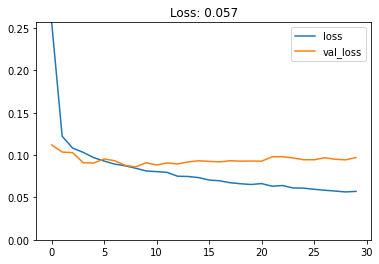

In [47]:
deep_model = Sequential()
deep_model.add(Dense(32, input_shape=(X.shape[1],), activation='relu'))
deep_model.add(Dense(16, activation='relu'))
deep_model.add(Dense(8, activation='relu'))
deep_model.add(Dense(1))

deep_model.compile('adam', 'mean_squared_error')

# early_stop = EarlyStopping(monitor='val_loss', patience=2, verbose=1)
deep_history = deep_model.fit(X_train, y_train, epochs=30, verbose=0, validation_split=0.2)
#                               callbacks=[early_stop])
plot_loss(deep_history)

Claramente estamos sobreajustando. La ANN está memorizando los datos de entrenamiento y esto está reduciendo su capacidad de generalizar en el conjunto de validación.

La regularización es un método creado para evitar el sobreajuste, sin embargo, podemos pensar en uno más simple, parar el procesamiento cuando se empiece a sentir el cambio entre la medida de las funciones de pérdida:

Epoch 5: early stopping


<Figure size 576x432 with 0 Axes>

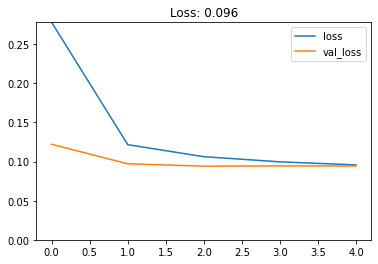

In [48]:
# con early stopping
deep_model = Sequential()
deep_model.add(Dense(32, input_shape=(X.shape[1],), activation='relu'))
deep_model.add(Dense(16, activation='relu'))
deep_model.add(Dense(8, activation='relu'))
deep_model.add(Dense(1))

deep_model.compile('adam', 'mean_squared_error')

early_stop = EarlyStopping(monitor='val_loss', patience=2, verbose=1)
deep_history = deep_model.fit(X_train, y_train, epochs=30, verbose=0, validation_split=0.2,
                              callbacks=[early_stop])
plot_loss(deep_history)

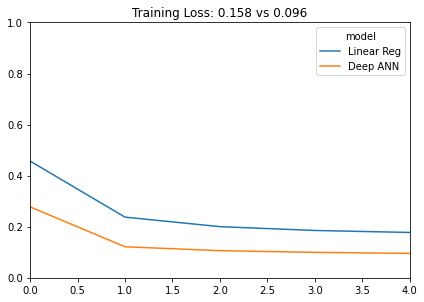

In [49]:
plot_compare_histories([linr_history, deep_history], ['Linear Reg', 'Deep ANN'], plot_accuracy=False)

In [50]:
def output_dollars(num):
    return '$'+str("{:,}".format(int(num)))

print('Average house price:', output_dollars(DF3['price'].mean()))

real_prices = ss_price.inverse_transform(y_test)

# print('Training set house price:', np.mean(ss_price.inverse_transform(y_train)))

train_prices = ss_price.inverse_transform(y_train)
dumb_prices = np.zeros(real_prices.shape)
dumb_prices.fill(train_prices.mean())
dumb_error = mean_absolute_error(real_prices, dumb_prices)
print('Dumb model error:', output_dollars(dumb_error))

linr_predictions = linr_model.predict(X_test).ravel()
linr_prices = ss_price.inverse_transform(linr_predictions)
linr_error = mean_absolute_error(real_prices, linr_prices)
print('Linear model error:', output_dollars(linr_error))

deep_predictions = deep_model.predict(X_test).ravel()
deep_prices = ss_price.inverse_transform(deep_predictions)
deep_error = mean_absolute_error(real_prices, deep_prices)
print('Deep model error:', output_dollars(deep_error))

tdf = pd.DataFrame([['Naive Model', output_dollars(dumb_error)], 
                    ['Linear Regression', output_dollars(linr_error)], 
                    ['Deep ANN', output_dollars(deep_error)]], 
                   columns=['Model', 'Price Error'])
tdf

Average house price: $540,088
Dumb model error: $229,981
136/136 [==============================] - 0s 928us/step


ValueError: Expected 2D array, got 1D array instead:
array=[-0.5921149   2.8287735   0.00768456 ... -0.49183035 -1.1101406
 -0.20820063].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

## Conclusiones

Usamos las redes neuronales para tres tipos de problemas típicos del Machine Learning, evidentemente el ajuste del modelo a los datos del entrenamiento produce potro gran lio, el sobreajuste, veremos como enfrentarlo en otro ejercicio. 
